# Домашнее задание
Практика по PyTorch

## Цель:
Получить навыки практической работы с PyTorch.


## Описание/Пошаговая инструкция выполнения домашнего задания:
Используя PyTorch:

Создать и обучить регрессионную модель, которая аппроксимирует значение функции sin(x + 2*y)exp(-(2x + y)^2) на диапазоне значений [-10;10] по х и у.
В качестве обучающей выборки необходимо сгенерировать 20000 точек случайным образом.
Разделить получившийся датасет на train / test / val в отношениях 70% / 15% / 15%, соответственно.
Результаты:
a) Посчитать метрику Mean Square Error(MSE) на test.
b) Нарисовать график, в котором сравнивается истинная функция и ее аппроксимированный вариант (предсказываемый моделью).

In [1]:
# импорты
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.autograd import Variable

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import os
import random
from tqdm.auto import tqdm

In [2]:
# наличие cuda на компьютере?
from torch.cuda import is_available
is_available()

False

In [3]:
# какой device?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
    torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

In [5]:
seed = 42
random_state = seed

In [6]:
seed_everything(seed)

# 1. Создать и обучить регрессионную модель, которая аппроксимирует значение функции sin(x + 2*y)exp(-(2x + y)^2) на диапазоне значений [-10;10] по х и у. В качестве обучающей выборки необходимо сгенерировать 20000 точек случайным образом.

In [7]:
def create_dataset():
    predict = []
    x_data = []
    y_data = []
    variables = []
    for i in range(5000): #в задании 20000 взял 5000 для скорости, 20000 не отрисовывает
        batch_variable = []
        x = random.randint(-10,10) 
        y = random.randint(-10,10)
    
        predict.append(math.sin(x + 2**y)*math.exp(-(2*x + y)**2))

        batch_variable.append(x)
        batch_variable.append(y)
        variables.append(batch_variable)
    return variables, predict

In [8]:
x_y, data = create_dataset()

In [9]:
data = pd.DataFrame(data)

In [10]:
x_y = pd.DataFrame(x_y)

In [11]:
data.head()

,0
0,-2.213283e-74
1,2.022869e-211
2,-1.749196e-36
3,4.758116e-158
4,1.530715e-16


In [12]:
x_y.head()

,0,1
0,10,-7
1,-10,-2
2,-3,-3
3,-6,-7
4,7,-8


# 2. Разделить получившийся датасет на train / test / val в отношениях 70% / 15% / 15%, соответственно. Результаты: a) Посчитать метрику Mean Square Error(MSE) на test. b) Нарисовать график, в котором сравнивается истинная функция и ее аппроксимированный вариант (предсказываемый моделью).

In [13]:
x_input = x_y
y_input = data

In [14]:
# Разделить получившийся датасет на train / test / val в отношениях 70% / 15% / 15%, соответственно
X_train, X_test, y_train, y_test  = train_test_split(x_input, y_input, test_size=0.3, random_state=random_state)

# разделю на 70% (train) + 30% (test + val), потом 30% разделю на 0,5*30%(= 15% test) +0,5*30%(= 15% val)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

In [15]:
# выведу размеры и доли 
print(f'X_train: {X_train.shape}, {X_train.shape[0]/x_input.shape[0]}')
print(f'y_train: {y_train.shape}, {y_train.shape[0]/y_input.shape[0]}')

print(f'X_test: {X_test.shape}, {X_test.shape[0]/x_input.shape[0]}')
print(f'y_test: {y_test.shape}, {y_test.shape[0]/y_input.shape[0]}')

print(f'X_val: {X_val.shape}, {X_val.shape[0]/x_input.shape[0]}')
print(f'y_val: {y_val.shape}, {y_val.shape[0]/y_input.shape[0]}')

X_train: (3500, 2), 0.7
y_train: (3500, 1), 0.7
X_test: (750, 2), 0.15
y_test: (750, 1), 0.15
X_val: (750, 2), 0.15
y_val: (750, 1), 0.15


In [16]:
# перевожу X_train, X_test, y_train, y_test, X_test, X_val, y_test, y_val из array в  pytorch tensor
x_train_tensor = torch.from_numpy(X_train.to_numpy())
y_train_tensor = torch.from_numpy(y_train.to_numpy())
x_test_tensor = torch.from_numpy(X_test.to_numpy())
y_test_tensor = torch.from_numpy(y_test.to_numpy())
x_val_tensor = torch.from_numpy(X_val.to_numpy())
y_val_tensor = torch.from_numpy(y_val.to_numpy())

In [17]:
# Создание ANN модели
class linearRegression(nn.Module):
                
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(linearRegression, self).__init__()
        
        # Линейная функция 1: 2 --> 150
        self.fc1 = nn.Linear(input_dim, hidden_dim1) 
        # Не линейная функция 1
        self.tanh1 = nn.Tanh()
        
        # Linear function 2: 150 --> 150
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # Не линейная функция 2
        self.tanh2 = nn.Tanh()
        
        # Linear function 3: 150 --> 150
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.sigmoid = nn.Sigmoid()
        # Не линейная функция 3: 150 --> 1

        self.fc4 = nn.Linear(hidden_dim3, output_dim)


    def forward(self, x):
        # Линейная функция 1
        out = self.fc1(x)
        # Не линейная функция 1
        out = self.tanh1 (out)
        
        # Линейная функция 2
        out = self.fc2(out)
        # Не линейная функция 2
        out = self.tanh2(out)
        
        # Линейная функция 3
        out = self.fc3(out)
        out = self.sigmoid(out)
        out = self.fc4(out)
        return out

In [18]:
# Зададим параметры сети
input_dim = 2
hidden_dim1 = 200 
hidden_dim2 = 198
hidden_dim3 = 150
output_dim = 1

In [19]:
# Создадим экземпляр linear Regression
model = linearRegression(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

In [20]:
# Зададим loss функцию как MSE
error = torch.nn.MSELoss() 

# ADAM оптимизатор
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
# обучение модели1
epochs = 1000
for epoch in range(epochs):
 
    if torch.cuda.is_available():
        inputs = Variable(x_train_tensor).cuda()
        labels = Variable(y_train_tensor).cuda()
    else:
        inputs = Variable(x_train_tensor)
        labels = Variable(y_train_tensor)

    optimizer.zero_grad()

    outputs = model(inputs.type(torch.FloatTensor))

    loss = error(outputs, labels.type(torch.FloatTensor))   
    loss.backward()

    optimizer.step()
    
    inputs2 = Variable(x_val_tensor)
    labels2 = Variable(y_val_tensor)
    outputs2 = model(inputs2.type(torch.FloatTensor))
    loss2 = error(outputs2, labels2.type(torch.FloatTensor))
    print('epoch {}, train_loss {}, validation_loss {}'.format(epoch, loss.item(), loss2.item()))

epoch 0, train_loss 0.31012162566185, validation_loss 0.20635390281677246
epoch 1, train_loss 0.20737561583518982, validation_loss 0.12828513979911804
epoch 2, train_loss 0.12876299023628235, validation_loss 0.0691593736410141
epoch 3, train_loss 0.07060691714286804, validation_loss 0.03295892849564552
epoch 4, train_loss 0.03553590551018715, validation_loss 0.018545273691415787
epoch 5, train_loss 0.021467480808496475, validation_loss 0.02190420590341091
epoch 6, train_loss 0.024815717712044716, validation_loss 0.03614112734794617
epoch 7, train_loss 0.03940408676862717, validation_loss 0.04893774911761284
epoch 8, train_loss 0.05257546529173851, validation_loss 0.05612247809767723
epoch 9, train_loss 0.059738077223300934, validation_loss 0.05512428656220436
epoch 10, train_loss 0.058393336832523346, validation_loss 0.04828709363937378
epoch 11, train_loss 0.051028914749622345, validation_loss 0.039158791303634644
epoch 12, train_loss 0.0413011871278286, validation_loss 0.030019797384

epoch 106, train_loss 0.015322001650929451, validation_loss 0.014107530936598778
epoch 107, train_loss 0.015259170904755592, validation_loss 0.014053704217076302
epoch 108, train_loss 0.015195761807262897, validation_loss 0.013997613452374935
epoch 109, train_loss 0.015132172033190727, validation_loss 0.013944536447525024
epoch 110, train_loss 0.01506839506328106, validation_loss 0.01388686615973711
epoch 111, train_loss 0.015004154294729233, validation_loss 0.013813967816531658
epoch 112, train_loss 0.01493921596556902, validation_loss 0.01373422984033823
epoch 113, train_loss 0.014873707666993141, validation_loss 0.013657744973897934
epoch 114, train_loss 0.014807798899710178, validation_loss 0.013579984195530415
epoch 115, train_loss 0.01474151574075222, validation_loss 0.013502899557352066
epoch 116, train_loss 0.014674735255539417, validation_loss 0.013436945155262947
epoch 117, train_loss 0.014607484452426434, validation_loss 0.013376075774431229
epoch 118, train_loss 0.014540019

epoch 209, train_loss 0.009535521268844604, validation_loss 0.009148833341896534
epoch 210, train_loss 0.009492846205830574, validation_loss 0.009164259769022465
epoch 211, train_loss 0.009449844248592854, validation_loss 0.00920102559030056
epoch 212, train_loss 0.009411687962710857, validation_loss 0.009075372479856014
epoch 213, train_loss 0.009371969848871231, validation_loss 0.009105434641242027
epoch 214, train_loss 0.00933064240962267, validation_loss 0.009118407964706421
epoch 215, train_loss 0.00929249357432127, validation_loss 0.008999318815767765
epoch 216, train_loss 0.009254186414182186, validation_loss 0.009054179303348064
epoch 217, train_loss 0.009213573299348354, validation_loss 0.009020118974149227
epoch 218, train_loss 0.009174485690891743, validation_loss 0.008944382891058922
epoch 219, train_loss 0.009136579930782318, validation_loss 0.008984186686575413
epoch 220, train_loss 0.009097064845263958, validation_loss 0.008941782638430595
epoch 221, train_loss 0.0090577

epoch 310, train_loss 0.006234514061361551, validation_loss 0.0070700435899198055
epoch 311, train_loss 0.006204616744071245, validation_loss 0.007057673297822475
epoch 312, train_loss 0.006174733862280846, validation_loss 0.007028062362223864
epoch 313, train_loss 0.006144859362393618, validation_loss 0.007017461117357016
epoch 314, train_loss 0.0061150179244577885, validation_loss 0.006985845044255257
epoch 315, train_loss 0.006085221655666828, validation_loss 0.0069779460318386555
epoch 316, train_loss 0.0060554989613592625, validation_loss 0.00694328173995018
epoch 317, train_loss 0.006025884300470352, validation_loss 0.006939710583537817
epoch 318, train_loss 0.005996431224048138, validation_loss 0.006900342181324959
epoch 319, train_loss 0.005967224016785622, validation_loss 0.006903843022882938
epoch 320, train_loss 0.0059384009800851345, validation_loss 0.006857162341475487
epoch 321, train_loss 0.005910184234380722, validation_loss 0.00687290308997035
epoch 322, train_loss 0.0

epoch 412, train_loss 0.0038003218360245228, validation_loss 0.005296656396239996
epoch 413, train_loss 0.003782963380217552, validation_loss 0.0052788774482905865
epoch 414, train_loss 0.003765698289498687, validation_loss 0.005265598651021719
epoch 415, train_loss 0.0037485253997147083, validation_loss 0.005247512832283974
epoch 416, train_loss 0.003731435164809227, validation_loss 0.005234557669609785
epoch 417, train_loss 0.003714432241395116, validation_loss 0.005215927958488464
epoch 418, train_loss 0.0036975168623030186, validation_loss 0.005203532055020332
epoch 419, train_loss 0.003680687863379717, validation_loss 0.005184045992791653
epoch 420, train_loss 0.003663957817479968, validation_loss 0.0051726787351071835
epoch 421, train_loss 0.0036473353393375874, validation_loss 0.00515187531709671
epoch 422, train_loss 0.003630837658420205, validation_loss 0.005142233334481716
epoch 423, train_loss 0.0036144955083727837, validation_loss 0.005119401030242443
epoch 424, train_loss 

epoch 513, train_loss 0.002431927714496851, validation_loss 0.003747911425307393
epoch 514, train_loss 0.0024203311186283827, validation_loss 0.003733835881575942
epoch 515, train_loss 0.0024087748024612665, validation_loss 0.0037170490249991417
epoch 516, train_loss 0.0023972338531166315, validation_loss 0.003702435176819563
epoch 517, train_loss 0.0023857078049331903, validation_loss 0.0036867072340101004
epoch 518, train_loss 0.002374226925894618, validation_loss 0.003670875448733568
epoch 519, train_loss 0.00236280495300889, validation_loss 0.0036564054898917675
epoch 520, train_loss 0.0023514237254858017, validation_loss 0.003639680566266179
epoch 521, train_loss 0.002340045990422368, validation_loss 0.0036255449522286654
epoch 522, train_loss 0.0023286445066332817, validation_loss 0.00360885146073997
epoch 523, train_loss 0.002317233709618449, validation_loss 0.0035942017566412687
epoch 524, train_loss 0.0023058410733938217, validation_loss 0.0035782232880592346
epoch 525, train_

epoch 616, train_loss 0.0013832551194354892, validation_loss 0.002298827050253749
epoch 617, train_loss 0.0013740144204348326, validation_loss 0.002287119859829545
epoch 618, train_loss 0.0013642831472679973, validation_loss 0.0022754755336791277
epoch 619, train_loss 0.0013555126497521996, validation_loss 0.002264095237478614
epoch 620, train_loss 0.0013476033927872777, validation_loss 0.0022541522048413754
epoch 621, train_loss 0.0013393685221672058, validation_loss 0.0022411381360143423
epoch 622, train_loss 0.0013303238665685058, validation_loss 0.0022298116236925125
epoch 623, train_loss 0.001321175484918058, validation_loss 0.002218525158241391
epoch 624, train_loss 0.0013126536505296826, validation_loss 0.0022070566192269325
epoch 625, train_loss 0.0013045818777754903, validation_loss 0.002196773886680603
epoch 626, train_loss 0.0012962894979864359, validation_loss 0.0021842424757778645
epoch 627, train_loss 0.0012875412357971072, validation_loss 0.002173077315092087
epoch 628, 

epoch 716, train_loss 0.0007299371645785868, validation_loss 0.0012839211849495769
epoch 717, train_loss 0.0006838397239334881, validation_loss 0.0012724518310278654
epoch 718, train_loss 0.0006740674143657088, validation_loss 0.0013085189275443554
epoch 719, train_loss 0.0006975451251491904, validation_loss 0.0012795062502846122
epoch 720, train_loss 0.0006915701669640839, validation_loss 0.0012611255515366793
epoch 721, train_loss 0.000669196539092809, validation_loss 0.0012589498655870557
epoch 722, train_loss 0.0006638904451392591, validation_loss 0.0012389173498377204
epoch 723, train_loss 0.0006596597959287465, validation_loss 0.0012370701879262924
epoch 724, train_loss 0.0006522095645777881, validation_loss 0.0012359978863969445
epoch 725, train_loss 0.0006549088866449893, validation_loss 0.0012224487727507949
epoch 726, train_loss 0.0006516495486721396, validation_loss 0.0012096810387447476
epoch 727, train_loss 0.0006339949904941022, validation_loss 0.001197334029711783
epoch 

epoch 815, train_loss 0.00047166558215394616, validation_loss 0.0009487749775871634
epoch 816, train_loss 0.0005656821886077523, validation_loss 0.0011191186495125294
epoch 817, train_loss 0.0007181515102274716, validation_loss 0.0013043911894783378
epoch 818, train_loss 0.000934681564103812, validation_loss 0.0015528092626482248
epoch 819, train_loss 0.0011554465163499117, validation_loss 0.001597850932739675
epoch 820, train_loss 0.00123743643052876, validation_loss 0.0014116223901510239
epoch 821, train_loss 0.0010195127688348293, validation_loss 0.0009783579735085368
epoch 822, train_loss 0.0006031474913470447, validation_loss 0.0007225187728181481
epoch 823, train_loss 0.00033922537113539875, validation_loss 0.0008182792807929218
epoch 824, train_loss 0.0004298619751352817, validation_loss 0.0010334465187042952
epoch 825, train_loss 0.0006662958185188472, validation_loss 0.001083041774109006
epoch 826, train_loss 0.0006998460157774389, validation_loss 0.0008589887875132263
epoch 8

epoch 915, train_loss 0.000191664497833699, validation_loss 0.00046857562847435474
epoch 916, train_loss 0.00019058452744502574, validation_loss 0.00046642773668281734
epoch 917, train_loss 0.0001894945016829297, validation_loss 0.0004645516164600849
epoch 918, train_loss 0.0001884036755654961, validation_loss 0.0004622696142178029
epoch 919, train_loss 0.0001873272267403081, validation_loss 0.00046045557246543467
epoch 920, train_loss 0.00018627027748152614, validation_loss 0.00045833978219889104
epoch 921, train_loss 0.00018522543541621417, validation_loss 0.0004563180555123836
epoch 922, train_loss 0.0001841828488977626, validation_loss 0.00045446815784089267
epoch 923, train_loss 0.0001831391709856689, validation_loss 0.00045224890345707536
epoch 924, train_loss 0.00018210009147878736, validation_loss 0.00045050898916088045
epoch 925, train_loss 0.00018107163487002254, validation_loss 0.0004483670345507562
epoch 926, train_loss 0.00018005525635089725, validation_loss 0.000446482503

In [22]:
inputs_test = Variable(x_test_tensor)
labels_test = Variable(y_test_tensor)
outputs_test = model(inputs_test.type(torch.FloatTensor))
loss2 = error(outputs_test, labels_test.type(torch.FloatTensor))

In [23]:
print(f'ошибка на тесте {loss2.detach().numpy()}')

ошибка на тесте 0.00014356891915667802


# графики

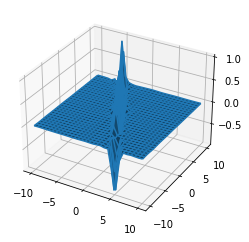

In [24]:
# pred
predictor = []
x, y = np.mgrid[-10.0:10.0:30j, -10.0:10.0:30j]

xy = np.column_stack([x.flat, y.flat])
for line in xy:

    g = np.array(line)
    inputs = Variable(torch.Tensor(g))
    predictor.append(model(inputs.type(torch.FloatTensor)).item())

z = np.array(predictor)

z = z.reshape(x.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x,y,z)
ax.plot_wireframe(x,y,z)

plt.show()
plt.show()

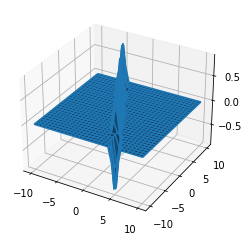

In [25]:
# input
predictor = []
x, y = np.mgrid[-10.0:10.0:30j, -10.0:10.0:30j]

xy = np.column_stack([x.flat, y.flat])

for line in xy:

    x_v = line[0]
    y_v = line[1]
    predictor.append(math.sin(x_v + 2**y_v)*math.exp(-(2*x_v + y_v)**2))

z = np.array(predictor)


z = z.reshape(x.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x,y,z)
ax.plot_wireframe(x,y,z)

plt.show()
plt.show()

<Figure size 2160x2160 with 0 Axes>

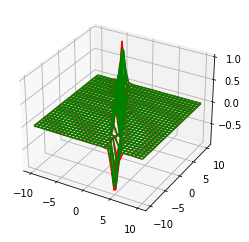

In [26]:
# pred + input
predictor1 = []
predictor2 = []
x, y = np.mgrid[-10.0:10.0:30j, -10.0:10.0:30j]
plt.figure(figsize=(30, 30))
xy = np.column_stack([x.flat, y.flat])

for line in xy:
    g = np.array(line)
    inputs = Variable(torch.Tensor(g))
    predictor1.append(model(inputs.type(torch.FloatTensor)).item())
    x_v = line[0]
    y_v = line[1]
    predictor2.append(math.sin(x_v + 2**y_v)*math.exp(-(2*x_v + y_v)**2))
z1 = np.array(predictor1)
z1 = z1.reshape(x.shape)


z2 = np.array(predictor2)

z2 = z2.reshape(x.shape)
mu1 = np.array([-1.5, -1.5])


fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
    
ax.plot_wireframe(x,y,z2, color="green")

ax.plot_wireframe(x,y,z1, color="red")


plt.show()

